In [46]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

path = "kaggle_3m"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

import os
import pandas as pd
from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from sklearn.preprocessing import OneHotEncoder

label_classes = ['RNASeqCluster','MethylationCluster','miRNACluster','CNCluster','RPPACluster','OncosignCluster','COCCluster','histological_type','neoplasm_histologic_grade']

class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, data_frame):
        self.root_dir = root_dir
        self.labels = data_frame
        self.labels.dropna(subset=['tumor_location'], inplace=True)
        encoder = OneHotEncoder(sparse=False)
        self.rna = encoder.fit_transform(self.labels[label_classes])
        self.transform = ToTensor()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        label = self.labels.loc[idx, 'death01']
        folder_name = self.labels.iloc[idx, 0]

        images = []

        for dir_name in os.listdir(self.root_dir):
            if dir_name.startswith(folder_name):
                img_folder = os.path.join(self.root_dir, dir_name)

                for img_name in sorted(os.listdir(img_folder)):
                    if not img_name.endswith('mask.tif'):
                        img_path = os.path.join(img_folder, img_name)

                        image = Image.open(img_path)
                        image = self.transform(image)
                        images.append(image)

        images = torch.stack(images)

        RNA_dat = self.rna[idx]
        return images.float().to(device), torch.tensor([label]).float().to(device), torch.tensor(RNA_dat).float().to(device)



df = pd.read_csv('kaggle_3m/data.csv')
df.dropna(subset=['death01'], inplace=True)
df = df.fillna(0)
# df = df.replace({'death01' : class_mapping})
print(df['death01'].unique())

dataset = ImageFolderDataset(root_dir='kaggle_3m', data_frame = df)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)


cuda
[1. 0.]


/home/sagie/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self,out_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(3, 3)
        self.conv2 = nn.Conv2d(5, 6, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(28*28*6, out_size)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        return x


class CombinedModel(nn.Module):
    def __init__(self,cnn_size,fc1_size,fc2_size):
        super(CombinedModel, self).__init__()
        self.cnn = CNN(cnn_size)
        self.fc1 = nn.Linear(36 + cnn_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.fc3 = nn.Linear(fc2_size, 1)

    def forward(self, x,rna):
        batch_size, timesteps, C, H, W = x.size()
        x = x.view(timesteps, C, H, W)
        x = self.cnn(x)
        x = x.view(batch_size, timesteps, -1)
        x = torch.mean(x,1)
        x = torch.cat((x,rna),1)
        x = F.sigmoid(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


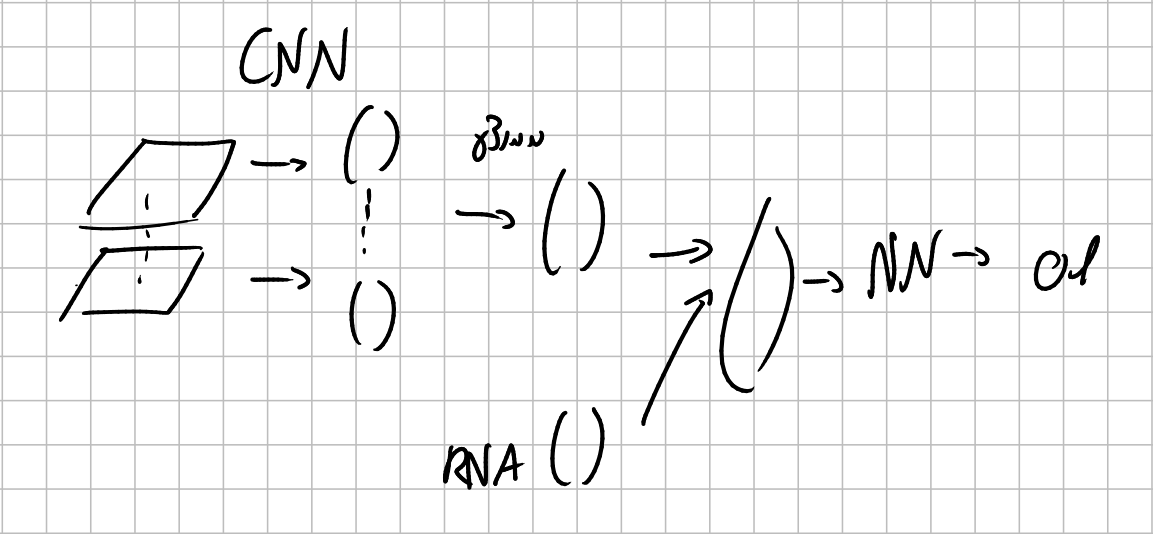
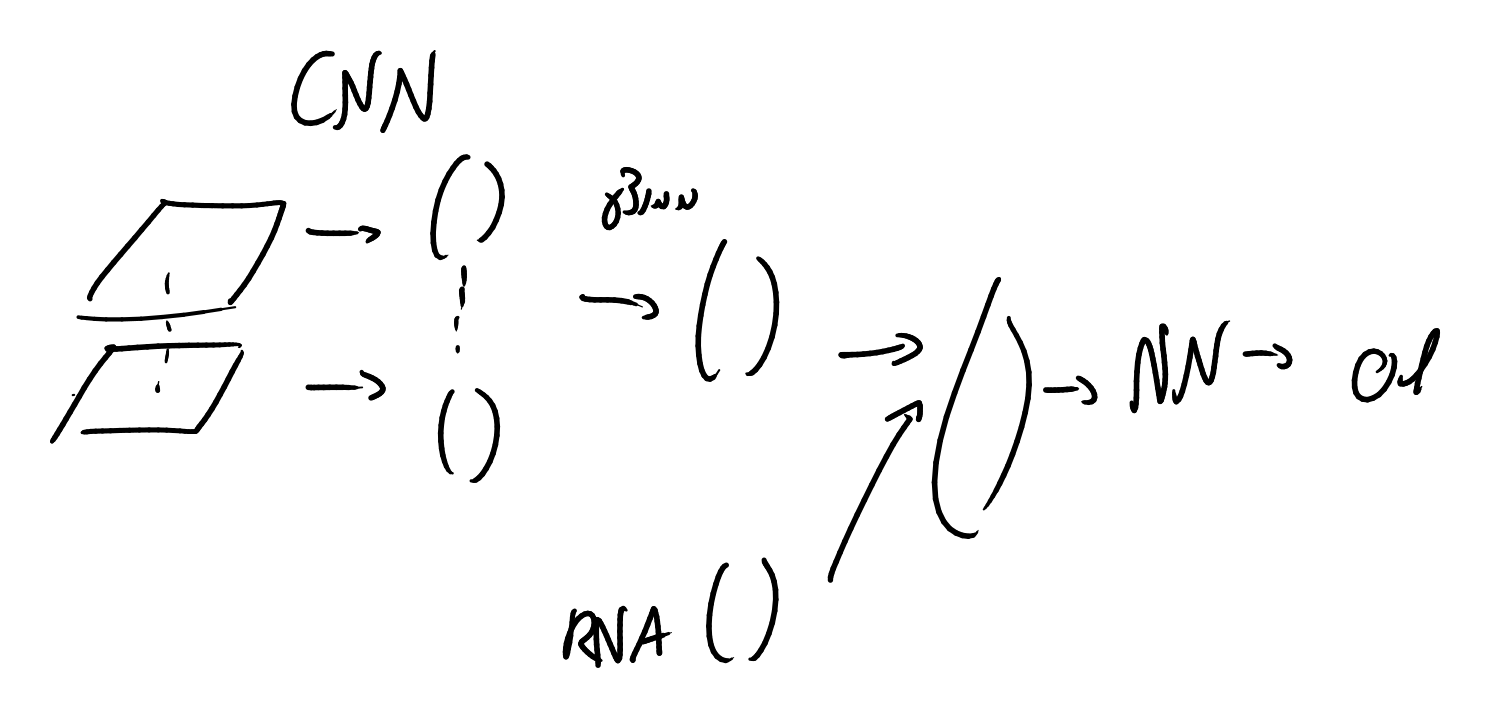

In [73]:
from sklearn.model_selection import KFold
import numpy as np
import torch.optim as optim


cnn_sizes = [2, 5, 10]
fc1_sizes = [20, 30, 50]
fc2_sizes = [10,20,30]
n_folds = 5

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=1)

best_accuracy = 0
best_cnn_size = 0
best_fc1_size = 0
best_fc2_size = 0


def BCELoss_class_weighted(weights):
    def loss(input, target):
        input = torch.clamp(input,min=1e-7,max=1-1e-7)
        bce = - weights[1] * target * torch.log(input) - (1 - target) * weights[0] * torch.log(1 - input)
        return torch.mean(bce)

    return loss

def train_and_evaluate_model(model, criterion, optimizer, train_indices, val_indices):
    train_subset = torch.utils.data.Subset(dataset, train_indices)
    val_subset = torch.utils.data.Subset(dataset, val_indices)

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=1, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=1, shuffle=True)

    num_epochs=7
    for epoch in range(num_epochs):
        for i, (inputs, labels, rna) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs, rna)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            torch.cuda.empty_cache()

    correct = 0
    total = 0
    with torch.no_grad():
        for i, (inputs, labels, rna) in enumerate(val_loader):
            outputs = model(inputs, rna)
            predicted = torch.round(outputs.data)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    return accuracy

for cnn_size in cnn_sizes:
    for fc1_size in fc1_sizes:
        for fc2_size in fc2_sizes:


            accuracy_list = []

            for train, val in kfold.split(dataset):

                model = CombinedModel(cnn_size, fc1_size,fc2_size).to(device)

                criterion = BCELoss_class_weighted([1, 4])

                optimizer = optim.Adam(model.parameters(), lr=0.01)

                accuracy = train_and_evaluate_model(model, criterion, optimizer, train, val)
                accuracy_list.append(accuracy)

            avg_accuracy = np.mean(accuracy_list)
            print(f"acc {avg_accuracy} cnn {cnn_size} fc {fc1_size,fc2_size}")

            if avg_accuracy > best_accuracy:
                best_accuracy = avg_accuracy
                best_cnn_size = cnn_size
                best_fc1_size = fc1_size
                best_fc2_size = fc2_size


print(f"Best cnn_size: {best_cnn_size}")
print(f"Best fc_size: {best_fc1_size,best_fc2_size}")
print(f"Best accuracy: {best_accuracy}")



KeyboardInterrupt: 

In [97]:
import torch.optim as optim

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
model = CombinedModel(5, 50,30).to(device)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True)

def BCELoss_class_weighted(weights):
    def loss(input, target):
        input = torch.clamp(input,min=1e-7,max=1-1e-7)
        bce = - weights[1] * target * torch.log(input) - (1 - target) * weights[0] * torch.log(1 - input)
        return torch.mean(bce)

    return loss

criterion = BCELoss_class_weighted([1,1])
optimizer = optim.Adam(model.parameters(), lr=0.01,amsgrad=True)

num_epochs = 15
for epoch in range(num_epochs):
    correct = 0
    total = 0
    for i, (inputs, labels,rna) in enumerate(train_loader):

        outputs = model(inputs,rna)
        loss = criterion(outputs, labels)

        predicted = torch.round(outputs.data)
        total += 1
        # print(predicted,labels)
        correct += (predicted == labels).sum().item()
        loss.backward()

        if i % 4 == 0: ## update the model in batches, hopefully more stable
            optimizer.step()
            optimizer.zero_grad()

        torch.cuda.empty_cache()

    accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Accuracy: {accuracy}%')

print("Training complete.")



Epoch 1/15, Loss: 1.8488373756408691, Accuracy: 67.816091954023%
Epoch 2/15, Loss: 0.23345017433166504, Accuracy: 74.71264367816092%
Epoch 3/15, Loss: 0.1912393420934677, Accuracy: 74.71264367816092%
Epoch 4/15, Loss: 0.27491122484207153, Accuracy: 74.71264367816092%
Epoch 5/15, Loss: 1.509620189666748, Accuracy: 74.71264367816092%
Epoch 6/15, Loss: 0.04942253232002258, Accuracy: 74.71264367816092%
Epoch 7/15, Loss: 0.023861007764935493, Accuracy: 79.3103448275862%
Epoch 8/15, Loss: 0.03018355928361416, Accuracy: 79.3103448275862%
Epoch 9/15, Loss: 0.11817310005426407, Accuracy: 79.3103448275862%
Epoch 10/15, Loss: 0.7476363182067871, Accuracy: 81.60919540229885%
Epoch 11/15, Loss: 0.00033491497742943466, Accuracy: 78.16091954022988%
Epoch 12/15, Loss: 0.6056786775588989, Accuracy: 83.9080459770115%
Epoch 13/15, Loss: 0.8073124885559082, Accuracy: 82.75862068965517%
Epoch 14/15, Loss: 0.5763067007064819, Accuracy: 83.9080459770115%
Epoch 15/15, Loss: 0.0007902525248937309, Accuracy: 81

In [99]:
correct = 0
total = 0

model.eval()
tp = 0
fp = 0
fn = 0
tn = 0
for inputs, labels,rna in val_loader:
    outputs = model(inputs,rna)
    predicted = torch.round(outputs.data)
    total += labels.size(0)

    tp += ((predicted == 1) and (labels == 1)).sum().item()
    fp += ((predicted == 1) and (labels == 0)).sum().item()
    fn += ((predicted == 0) and (labels == 1)).sum().item()
    tn += ((predicted == 0) and (labels == 0)).sum().item()


accuracy = 100 * (tp+tn) / (tp+tn+fn+fp)
precision = 100 * (tp) / (tp+fp)
recall = 100 * (tp) / (tp + fn)
print(tp,tn,fp,fn)
print("acc",accuracy,"precision",precision,"recall",recall)

1 15 2 4
acc 72.72727272727273 precision 33.333333333333336 recall 20.0


Results

lr | b | epoch | ams | weight| acc | pre | rec
0.01 4  10      True   4       63    38    100
0.01 8  15      True   2       Overfit
0.01 8  8       True   2       Stuck only false
0.01 8  8       True   2       68    33    40
0.01 8  10      True   4       54    11    33
0.01 4  6       True   2       72    50    33
0.01 4  6       True   1       86    66    50
